<a href="https://colab.research.google.com/github/Stefano-Previti/Diffusion_Based_Generative_Refiner/blob/main/Diffiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶
**DESCRIPTION OF THE PROJECT**

✈
The implementation propose a slightly variant of the proposed original architecture, in wich there will be a classical LSGAN approach for the loss in the speech enhancement module and some alternatives in the architectural choiches for the diffusion model.

**Overview of the original project**

First the training of a diffusion-based generative model on
clean speech data. After obtaining results from the SEGAN model, the variance of the noise included in noisy
input at each time-frequency bin is estimated. With the estimate, the proposed refiner generates clean speech on the basis of
the DDRM framework, which utilizes the trained diffusion-based model.

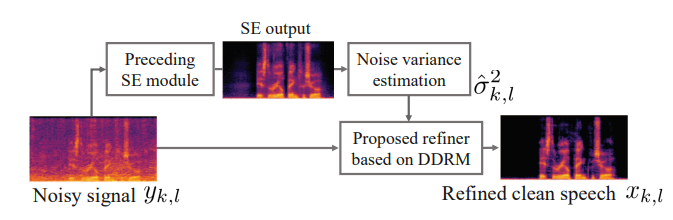

**⏰Variant for the loss in the SEGAN model**

The loss will be without the conditioned extra information in order to prove the **classical LSGAN** approach.

**⏰Variant for experiments in the DIFFUSION model**


1.   Classical standard convolution operations substituted by the **depthwise separable convolution**.
2. Single head substituted by **n-heads=2** in the attention block.

3. Training with 3 different activation function: **SilU,ReLU and GeLU**.




**▶LOAD** **THE** **DATASET**

⚓Loading of clean and noisy dataset composed, in both cases, by 28 speakers.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

# Defining paths to your ZIP files on Google Drive
zip_clean_train = '/content/drive/My Drive/clean_trainset_28spk_wav.zip'
zip_noisy_train = '/content/drive/My Drive/noisy_trainset_28spk_wav.zip'
zip_clean_test = '/content/drive/My Drive/clean_testset_wav.zip'
zip_noisy_test = '/content/drive/My Drive/noisy_testset_wav.zip'

# Defining extraction directories
clean_dir = '/content/data/clean_trainset/'
noisy_dir = '/content/data/noisy_trainset/'
clean_test_dir = '/content/data/clean_testset/'
noisy_test_dir = '/content/data/noisy_testset/'

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Creation of directories for extraction
create_directory(clean_dir)
create_directory(noisy_dir)
create_directory(clean_test_dir)
create_directory(noisy_test_dir)

# Function to extract ZIP files
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extraction of each ZIP file to its corresponding directory
extract_zip(zip_clean_train, clean_dir)
extract_zip(zip_noisy_train, noisy_dir)
extract_zip(zip_clean_test, clean_test_dir)
extract_zip(zip_noisy_test, noisy_test_dir)




In [ ]:
#  Verification of the extraction by listing files in all subdirectories
def verify_extraction(directory, num_files_to_check=6):
    # Walking through all directories and files
    for root, dirs, files in os.walk(directory):
        print(f'Checking directory: {root}')

        # Showing some files (up to num_files_to_check) in this directory
        for i, file_name in enumerate(files[:num_files_to_check]):
            file_path = os.path.join(root, file_name)
            print(f'File {i+1}: {file_path}')

# Running the verification functions
verify_extraction(clean_dir)
verify_extraction(noisy_dir)
verify_extraction(clean_test_dir)
verify_extraction(noisy_test_dir)


⚓Creation of a custom dataset object.

⏰The choice is to load only 1/4 of each dataset,after a random shuffling, because of the limitation of the RAM in the colab enviroment.

In [ ]:
# Installing PyTorch and torchaudio
!pip install torch torchvision torchaudio

In [ ]:
import torch
import torchaudio
import random
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, data_dir):
        """
        Initialization of the dataset with audio files from the specified directory and its subdirectories.
        """
        self.data_dir = data_dir
        self.files = self._get_subset_of_audio_files(data_dir)

    def _get_subset_of_audio_files(self, directory):
        """
        Recursively collecting a subset (1/4) of all audio files in the directory and its subdirectories.
        """
        audio_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.wav'):
                    audio_files.append(os.path.join(root, file))

        # Shuffling the list of files and taking 1/4 of it
        random.shuffle(audio_files)
        index = len(audio_files) // 4
        return sorted(audio_files[:index])


    def __len__(self):
        """Returning the number of audio files."""
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loading and returning the waveform and sample rate for a specific index.
        """
        file_path = os.path.join(self.data_dir, self.files[idx])
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} is not a file")

        waveform, sample_rate = torchaudio.load(file_path)
        return {'waveform': waveform, 'sample_rate': sample_rate}

    def compute_stft(self,waveform):
     """
     Computing the STFT of the waveform using a Hann window and returning a
     256x256 tensor with real and imaginary parts as separate channels.
     """
     # Defining th STFT parameters
     n_fft = 512
     hop_length = 256
     win_length = 512
     window_fn = torch.hann_window

     # Performing STFT
     stft_transform = T.Spectrogram(
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window_fn=window_fn,
        power=None,
     )
     stft_spectrogram = stft_transform(waveform)

     # Truncation of the DC component
     stft_spectrogram = stft_spectrogram[:, 1:, :]

     # Extraction of real and imaginary parts
     real_part = stft_spectrogram.real
     imag_part = stft_spectrogram.imag

     # Stacking into a tensor with two channels
     two_channel_tensor = torch.stack((real_part, imag_part), dim=1)

     # Ensuring the size is 256x256 for the selected time frames and frequency bins
     two_channel_tensor = two_channel_tensor[:, :, :256, :256]

     return two_channel_tensor

# Parameters
batch_size = 8

# Creation of dataset instances
clean_train_dataset = AudioDataset(clean_dir)
noisy_train_dataset = AudioDataset(noisy_dir)
clean_test_dataset = AudioDataset(clean_test_dir)
noisy_test_dataset = AudioDataset(noisy_test_dir)

# Print dataset lengths
print("Number of samples in clean_train_dataset:", len(clean_train_dataset))
print("Number of samples in noisy_train_dataset:", len(noisy_train_dataset))
print("Number of samples in clean_test_dataset:", len(clean_test_dataset))
print("Number of samples in noisy_test_dataset:", len(noisy_test_dataset))

#Custom collate function to handle variable-length audio files in order to avoid the runtime exception of the DataLoader
def collate_fn(batch):
    waveforms = [item['waveform'] for item in batch]
    sample_rates = [item['sample_rate'] for item in batch]
    return {'waveform': waveforms, 'sample_rate': sample_rates}

# Creation of DataLoader instances
clean_train_loader = DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
clean_test_loader = DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



▶**PREPROCESSING OF THE DATA**

⚓Here the pre-processing of the data through the computation
of the STFT parameters.

The **short-time Fourier transform** (STFT) is used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time.The procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment in order to reveal its spectrum.

In [ ]:
def STFT_preprocess_and_save(dataset,data_loader, output_dir):
    """
    Preprocesses the dataset by computing the STFT for each waveform and saving each STFT tensor as a separate file.

    Parameters:
    - data_loader: A DataLoader object providing batches of audio data.
    - output_dir: The directory where the individual STFT tensor files will be saved.
    """
    # Ensuring the destination directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialization of a counter for processed files
    file_counter = 0

    # Iterate over each batch in the data loader
    for batch_index, batch_data in enumerate(data_loader):
        # Assuming batch_data is a dictionary containing 'waveform'
        waveforms = batch_data['waveform']

        # Computing the STFT for each waveform in the batch
        for waveform_index, waveform in enumerate(waveforms):
            # Computing the STFT for the current waveform
            stft_tensor = dataset.compute_stft(waveform)

            # Definition of the file name for the current tensor
            file_name = f"stft_tensor_{file_counter}.pt"
            file_path = os.path.join(output_dir, file_name)

            # Saving the STFT tensor to a file
            torch.save(stft_tensor, file_path)

            # Incrementing the file counter
            file_counter += 1

            # Logging progress every 10 files
            if file_counter % 10 == 0:
                print(f"File {file_counter}/{len(data_loader.dataset)} processed and saved to {file_path}")

    print(f"All tensors have been processed and saved to {output_dir}")

# Directory Paths
STFT_clean_preprocessed_dir = '/content/drive/My Drive/STFT_clean_preprocessed/'
STFT_clean_test_preprocessed_dir = '/content/drive/My Drive/STFT_clean_test_preprocessed/'
STFT_noisy_preprocessed_dir = '/content/drive/My Drive/STFT_noisy_preprocessed/'
STFT_noisy_test_preprocessed_dir = '/content/drive/My Drive/STFT_noisy_test_preprocessed/'

#Calling the function
STFT_preprocess_and_save(clean_train_dataset,clean_train_loader, STFT_clean_preprocessed_dir)
STFT_preprocess_and_save(clean_test_dataset,clean_test_loader, STFT_clean_test_preprocessed_dir)
STFT_preprocess_and_save(noisy_train_dataset,noisy_train_loader, STFT_noisy_preprocessed_dir)
STFT_preprocess_and_save(noisy_test_dataset,noisy_test_loader, STFT_noisy_test_preprocessed_dir)


⚓Here the preprocessing for the waveform of each audio resampling to 16khz and then dividing it in segment of 16384 samples


In [ ]:
def waveform_preprocess_and_save(dataloader, output_dir, segment_length=16384):
    """
    Preprocess audio data from a DataLoader and save the preprocessed files.

    Args:
        dataloader (DataLoader): DataLoader instance that provides audio data.
        output_dir (str): Directory to save the preprocessed data.
        segment_length (int): Length of audio segments in samples.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    audio_id=0
    for batch_idx, batch in enumerate(dataloader):
        for idx in range(len(batch['waveform'])):
            audio_id+=1
            waveform = batch['waveform'][idx]
            sample_rate = batch['sample_rate'][0]

            # Resampling if necessary
            target_sample_rate = 16000
            if sample_rate != target_sample_rate:
                resample_transform = T.Resample(sample_rate, target_sample_rate)
                waveform = resample_transform(waveform)

            # Segmenting the audio into multiple parts
            length = waveform.size(1)
            num_segments = (length) // segment_length

            for segment_idx in range(num_segments):
                start = segment_idx * segment_length
                end = start + segment_length

                segment = waveform[:, start:end]

                # Saving each segment
                file_name = f"{audio_id}_{segment_idx}.pt"
                save_path = os.path.join(output_dir, file_name)
                torch.save(segment, save_path)

                print(f"Saved preprocessed segment: {save_path}")


# Directory Paths
waveform_clean_preprocessed_dir = '/content/drive/My Drive/waveform_clean_preprocessed/'
waveform_clean_test_preprocessed_dir='/content/drive/My Drive/waveform_clean_test_preprocessed/'
waveform_noisy_preprocessed_dir = '/content/drive/My Drive/waveform_noisy_preprocessed/'
waveform_noisy_test_preprocessed_dir = '/content/drive/My Drive/waveform_noisy_test_preprocessed/'

#Calling the function
waveform_preprocess_and_save(clean_train_loader, waveform_clean_preprocessed_dir)
waveform_preprocess_and_save(clean_test_loader, waveform_clean_test_preprocessed_dir)
waveform_preprocess_and_save(noisy_train_loader, waveform_noisy_preprocessed_dir)
waveform_preprocess_and_save(noisy_test_loader, waveform_noisy_test_preprocessed_dir)


**SEGAN**

⚓
The **SEGAN** (Speech Enhancement Generative Adversarial Network) architecture is model designed for speech enhancement tasks, particularly to reduce noise in audio signals. It uses a generative adversarial network (GAN) framework, where a generator network aims to produce clean, enhanced speech from noisy input, and a discriminator network attempts to distinguish between the enhanced speech and the original clean speech. Through this **adversarial training**, the SEGAN model effectively learns to improve the quality of noisy speech, making it sound more natural and intelligible.




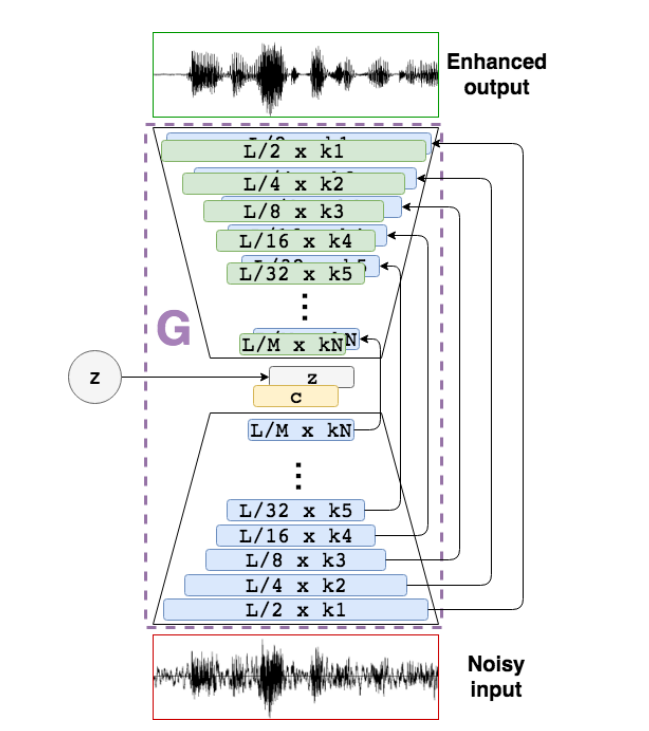

**⏰Scaling of the architecture**

Here there is a **scaled** model in order to achieve a better performance in terms of time-consuming during training.

The model goes up to a maximum of 256 channels instead of the 1024 reached by the paper.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Defining the encoder layers
        self.enc1 = nn.Conv1d(1, 8, kernel_size=31, stride=2, padding=15)  # Encoding input to 8 channels
        self.enc2 = nn.Conv1d(8, 16, kernel_size=31, stride=2, padding=15) # Encoding to 16 channels
        self.enc3 = nn.Conv1d(16, 32, kernel_size=31, stride=2, padding=15) # Encoding to 32 channels
        self.enc4 = nn.Conv1d(32, 64, kernel_size=31, stride=2, padding=15) # Encoding to 64 channels
        self.enc5 = nn.Conv1d(64, 128, kernel_size=31, stride=2, padding=15) # Encoding to 128 channels
        self.enc6 = nn.Conv1d(128, 256, kernel_size=31, stride=2, padding=15) # Encoding to 256 channels

        # Defining the decoder layers with output padding to correct dimension mismatch
        self.dec1 = nn.ConvTranspose1d(256, 128, kernel_size=31, stride=2, padding=15, output_padding=1) # Decoding to 128 channels
        self.dec2 = nn.ConvTranspose1d(128, 64, kernel_size=31, stride=2, padding=15, output_padding=1) # Decoding to 64 channels
        self.dec3 = nn.ConvTranspose1d(64, 32, kernel_size=31, stride=2, padding=15, output_padding=1)  # Decoding to 32 channels
        self.dec4 = nn.ConvTranspose1d(32, 16, kernel_size=31, stride=2, padding=15, output_padding=1)  # Decoding to 16 channels
        self.dec5 = nn.ConvTranspose1d(16, 8, kernel_size=31, stride=2, padding=15, output_padding=1)   # Decoding to 8 channels
        self.dec6 = nn.ConvTranspose1d(8, 1, kernel_size=31, stride=2, padding=15, output_padding=1)     # Decoding to 1 output channel

        # Defining a PReLU activation layer
        self.prelu = nn.PReLU()

        # Defining the tanh
        self.tanh=nn.Tanh()

    def forward(self, x):
        # Passing through the encoder while applying PReLU activation
        x1 = self.prelu(self.enc1(x))  # Encoding first layer
        x2 = self.prelu(self.enc2(x1)) # Encoding second layer
        x3 = self.prelu(self.enc3(x2)) # Encoding third layer
        x4 = self.prelu(self.enc4(x3)) # Encoding fourth layer
        x5 = self.prelu(self.enc5(x4)) # Encoding fifth layer
        x6 = self.prelu(self.enc6(x5)) # Encoding sixth layer

        # Passing through the decoder while applying skip connections and PReLU activation
        x = self.prelu(self.dec1(x6 + x6[:, :, :x.size(2)])) # Adding skip connection from the sixth encoder layer
        x = self.prelu(self.dec2(x + x5[:, :, :x.size(2)])) # Adding skip connection from the fifth encoder layer
        x = self.prelu(self.dec3(x + x4[:, :, :x.size(2)])) # Adding skip connection from the fourth encoder layer
        x = self.prelu(self.dec4(x + x3[:, :, :x.size(2)])) # Adding skip connection from the third encoder layer
        x = self.prelu(self.dec5(x + x2[:, :, :x.size(2)])) # Adding skip connection from the second encoder layer
        x = self.prelu(self.dec6(x + x1[:, :, :x.size(2)])) # Adding skip connection from the first encoder layer
        return self.tanh(x)

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The Discriminator has a similar architecture as the Encoder of the Generator
        self.conv1 = nn.Conv1d(2, 8, kernel_size=31, stride=2, padding=15)
        self.bn1 = nn.BatchNorm1d(8)  # Batch normalization
        self.conv2 = nn.Conv1d(8, 16, kernel_size=31, stride=2, padding=15)
        self.bn2 = nn.BatchNorm1d(16)  # Batch normalization
        self.conv3 = nn.Conv1d(16, 32, kernel_size=31, stride=2, padding=15)
        self.bn3 = nn.BatchNorm1d(32)  # Batch normalization
        self.conv4 = nn.Conv1d(32, 64, kernel_size=31, stride=2, padding=15)
        self.bn4 = nn.BatchNorm1d(64)  # Batch normalization
        self.conv5 = nn.Conv1d(64, 128, kernel_size=31, stride=2, padding=15)
        self.bn5 = nn.BatchNorm1d(128)  # Batch normalization
        self.conv6 = nn.Conv1d(128, 256, kernel_size=31, stride=2, padding=15)
        self.bn6 = nn.BatchNorm1d(256)  # Batch normalization

        # Output layer for Discriminator
        self.fc = nn.Conv1d(256, 1, kernel_size=1, stride=1)  # 1×1 convolution to reduce to a single output

    def forward(self, x):
        x1 = self.bn1(self.conv1(x))
        x1 = F.leaky_relu(x1, 0.3)
        x2 = self.bn2(self.conv2(x1))
        x2 = F.leaky_relu(x2, 0.3)
        x3 = self.bn3(self.conv3(x2))
        x3 = F.leaky_relu(x3, 0.3)
        x4 = self.bn4(self.conv4(x3))
        x4 = F.leaky_relu(x4, 0.3)
        x5 = self.bn5(self.conv5(x4))
        x5 = F.leaky_relu(x5, 0.3)
        x6 = self.bn6(self.conv6(x5))
        x6 = F.leaky_relu(x6, 0.3)

        # Final output
        x = self.fc(x6)  # 1D convolution output
        return x

▶
**Training**



1.   The **Generator** strives to minimize the loss, which means it want to fool the Discriminator into believing its generated data is real.
2.   The **Discriminator**, on the other hand, aims to minimize its loss by accurately distinguish real data from generated data.



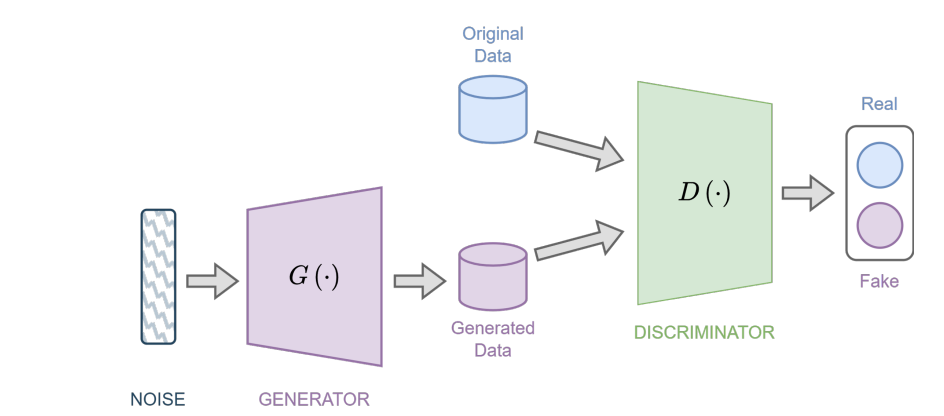

**⏰Variant for the loss**

The loss will be without the conditioned extra information in order to prove the **classical LSGAN** approach.

Here showed the (general) equation of the loss using the **least-squares GAN**
(LSGAN) approach obtained with
the least-squares function.

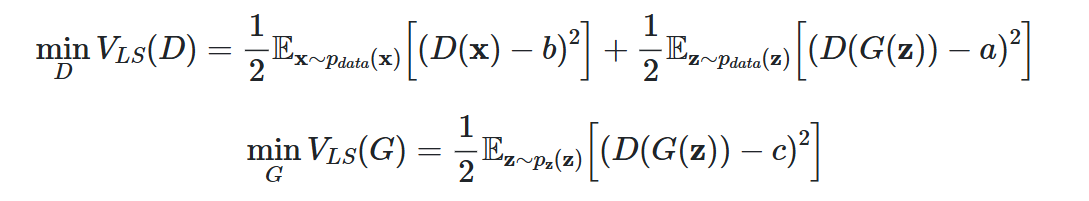

In this  specific case the generic parameters (a,b,c) are substituted with binary coding(1 for real, 0 for
fake).

Moreover there is an **L1 regularization** added in the **generator loss** as suggested by the paper

->
**Adaptation for the speech enhancement task**

1.   The concatenation of the noisy with the clean signal should be identified from the discriminator as True.

2.   The concatenation of the noisy with the enhanced signal should be identified from the discriminator as False.

3. The generator want to make True the identification of the discriminator about the concatenation of the noisy signal with the enhanced signal.



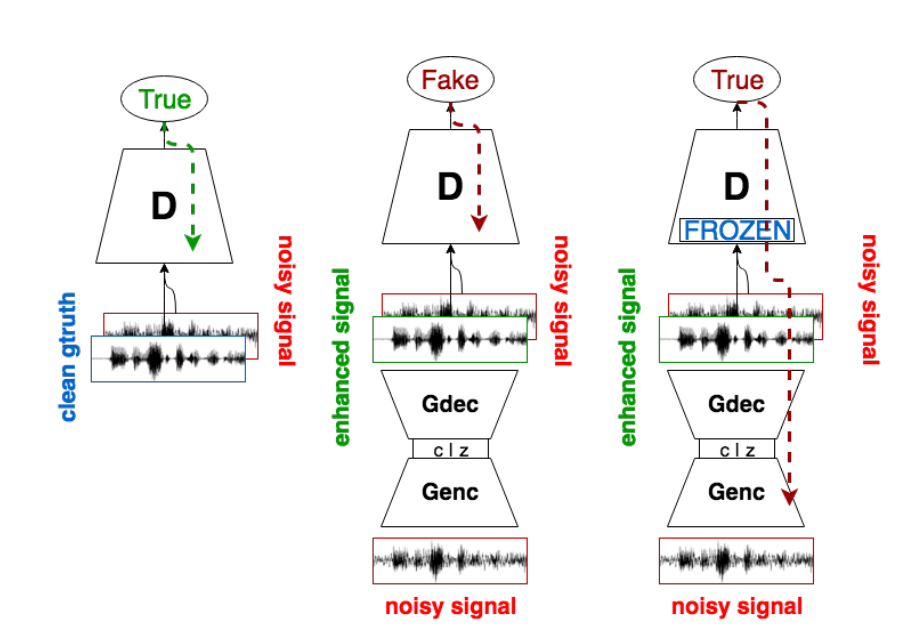

⚓
The code also includes:

1. **Model Checkpointing**: The model is saved after every epoch to Google Drive, ensuring progress isn't lost.

2. **Evaluation**: After each epoch, the generator's performance is evaluated on a separate dataset.

In [ ]:
!pip install --upgrade torchaudio torch

In [ ]:
import torch
import random
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import os
from google.colab import drive

#Loading the samples
def load_samples(directory):
    samples = []
    for root_dir, dirs, files in os.walk(directory):
        files.sort()
        for filename in files:
            if filename.endswith('.pt'):
                filepath = os.path.join(directory, filename)
                sample = torch.load(filepath)
                samples.append(sample)
    return samples

class ProcessedAudioDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample= self.samples[idx]
        return sample

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')
waveform_clean_preprocessed_dir = '/content/drive/My Drive/waveform_clean_preprocessed'
waveform_clean_test_preprocessed_dir = '/content/drive/My Drive/waveform_clean_test_preprocessed'
samples = load_samples(waveform_clean_preprocessed_dir)
test_samples= load_samples(waveform_clean_test_preprocessed_dir)

# Creation of the DataLoader
batch_size = 8
Segan_train_dataset = ProcessedAudioDataset(samples)
Segan_test_dataset= ProcessedAudioDataset(test_samples)

# Setting the ratio for the set
eval_ratio = 0.20

# Calculate the sizes of the datasets
total_size = len(Segan_train_dataset)
eval_size = int(total_size * eval_ratio)
train_size = total_size - eval_size

# Splitting the dataset
Segan_train_dataset, Segan_eval_dataset = random_split(Segan_train_dataset, [train_size, eval_size])

#Creation of the data loader
Segan_train_data_loader = DataLoader(Segan_train_dataset, batch_size=batch_size, shuffle=True)
Segan_eval_data_loader = DataLoader(Segan_eval_dataset, batch_size=batch_size, shuffle=False)
Segan_test_data_loader = DataLoader(Segan_test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.optim as optim
import torch.nn as nn
import random
import torchaudio
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio.functional as aud_f

def loss_function_D(real, fake,device):
    # Cross-entropy loss for the Discriminator
    criterion = nn.MSELoss()

    # Real and fake labels
    real_labels = torch.ones(real.size(0), 1, real.size(2)).to(device)
    fake_labels = torch.zeros(fake.size(0), 1, fake.size(2)).to(device)

    # Discriminator loss
    real_loss = criterion(real, real_labels)
    fake_loss = criterion(fake, fake_labels)
    d_loss = (real_loss + fake_loss)/2

    return d_loss

def loss_function_G(fake_out_d,real_data,fake_data,device,lambda_l1=0.001):
    # Cross-entropy loss for the Generator
    criterion = nn.MSELoss()
    real_labels = torch.ones(fake_out_d.size(0), 1, fake_out_d.size(2)).to(device)

    # Generator loss
    g_loss = criterion(fake_out_d, real_labels)

    # L1 loss for regularization
    l1_loss = torch.mean(torch.abs(fake_data - real_data))

    # Total Generator loss with L1 regularization
    total_g_loss = (g_loss/2) + (lambda_l1 * l1_loss)

    return total_g_loss


drive.mount('/content/drive')

# Creating the directory for the checkpoint if it doesn't exist
checkpoint_dir = '/content/drive/My Drive/Segan_model_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining the filename for the checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')

def save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, checkpoint_path, g_scheduler, d_scheduler):
    # Saving the model state and optimizers
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'g_scheduler_state_dict': g_scheduler.state_dict(),
        'd_scheduler_state_dict': d_scheduler.state_dict()
    }, checkpoint_path)

def load_checkpoint(checkpoint_path, generator, discriminator, g_optimizer, d_optimizer, g_scheduler, d_scheduler):
    # Loading the model state  and optimizers
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    g_scheduler.load_state_dict(checkpoint['g_scheduler_state_dict'])
    d_scheduler.load_state_dict(checkpoint['d_scheduler_state_dict'])
    return checkpoint['epoch']


def train(generator, discriminator,train_dataloader, num_epochs, lr, checkpoint_path, eval_dataloader, device):
    # Initializing optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

    # Defining the scheduler
    g_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, min_lr=1e-6)
    d_scheduler = ReduceLROnPlateau(d_optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, min_lr=1e-6)

    for epoch in range( num_epochs):
        # Loading the model if it's not the first epoch
        if epoch > 0 and os.path.exists(checkpoint_path):
            load_checkpoint(checkpoint_path, generator, discriminator, g_optimizer, d_optimizer, g_scheduler, d_scheduler)
            print(f"Model loaded from {checkpoint_path} at the start of epoch {epoch + 1}")

        # Setting model to training mode
        generator.train()
        discriminator.train()

        # Initializing loss accumulators for each epoch
        total_d_loss = 0.0
        total_g_loss = 0.0

        for real_data in train_dataloader:
            batch_size = real_data.size(0)
            clean_data = real_data.to(device)

            # Generating noise
            noise = torch.randn_like(clean_data).to(device) * random.uniform(0, 0.3)

             # Adding noise to the clean data with a randomly chosen SNR
            snr_values = [random.choice([0, 5, 10, 15]) for _ in range(batch_size)]  # Random SNR for each item in the batch
            snr=torch.tensor(snr_values).to(device)
            snr=snr.unsqueeze(1)
            noisy_data = (aud_f.add_noise(clean_data, noise, snr, None)).to(device)

            # Generating enhanced data with the generator
            enhanced_data = generator(noisy_data)

            # Training the discriminator
            d_optimizer.zero_grad()

            # Getting discriminator outputs
            real_out_d = discriminator(torch.cat((noisy_data, clean_data), dim=1))
            fake_out_d = discriminator(torch.cat((noisy_data, enhanced_data), dim=1))

            # Calculating discriminator loss
            d_loss = loss_function_D(real_out_d, fake_out_d,device)
            d_loss.backward(retain_graph=True)
            d_optimizer.step()

            # Accumulating discriminator loss
            total_d_loss += d_loss.item()

            # Training the generator
            g_optimizer.zero_grad()
            fake_out_d = discriminator(torch.cat((noisy_data, enhanced_data), dim=1))

            # Calculating generator loss
            g_loss = loss_function_G(fake_out_d,clean_data,enhanced_data, device)
            g_loss.backward()
            g_optimizer.step()

            # Accumulating generator loss
            total_g_loss += g_loss.item()

            # Calculating average losses for the epoch
            avg_d_loss = total_d_loss / len(train_dataloader)
            avg_g_loss = total_g_loss / len(train_dataloader)

        print(f'Epoch [{epoch + 1}/{num_epochs}], avg_d_loss: {avg_d_loss:.4f}, avg_g_loss: {avg_g_loss:.4f}')

        # Saving checkpoint after each epoch
        save_checkpoint(epoch, generator, discriminator, g_optimizer, d_optimizer, checkpoint_path, g_scheduler, d_scheduler)

        # Evaluating the model
        if eval_dataloader is not None:
            generator.eval()  # Setting generator to evaluation mode
            discriminator.eval() #Setting discriminator to evaluation mode
            total_eval_loss = 0 # Initializing total evaluation loss

            with torch.no_grad():
                for eval_real_data in eval_dataloader:
                    eval_clean_data = eval_real_data.to(device)

                    # Generating noise
                    noise = torch.randn_like(eval_clean_data).to(device) * random.uniform(0, 0.3)

                    # Adding noise to the clean data with a randomly chosen SNR
                    snr_values = [random.choice([0, 5, 10, 15]) for _ in range(eval_clean_data.size(0))]  # Random SNR for each item in the batch
                    snr=torch.tensor(snr_values).to(device)
                    snr=snr.unsqueeze(1)
                    eval_noisy_data = (aud_f.add_noise(eval_clean_data, noise, snr, None)).to(device)

                    # Generating enhanced data using the generator
                    eval_enhanced_data = generator(eval_noisy_data)

                    # Calculate generator loss on evaluation dataset
                    eval_fake_out = discriminator(torch.cat((eval_noisy_data, eval_enhanced_data), dim=1))
                    eval_loss = loss_function_G(eval_fake_out,eval_clean_data,eval_enhanced_data,device)
                    total_eval_loss += eval_loss.item()

                avg_eval_loss = total_eval_loss /len(eval_dataloader)
                print(f'Average evaluation loss after epoch {epoch + 1}: {avg_eval_loss:.4f}')

                #Updating the scheduler
                g_scheduler.step(avg_eval_loss)
                d_scheduler.step(avg_eval_loss)

# Setting the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs=65
lr=0.001

# Initializing the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Call the training function
train(generator, discriminator, Segan_train_data_loader, epochs, lr, checkpoint_path, Segan_eval_data_loader, device)


**▶Testing**


⚓Testing considering the average loss.

In [ ]:
def test(generator, test_dataloader,device):
    # Setting the generator to evaluation mode
    generator.eval()
    total_test_loss = 0 # Initializing total loss


    # Disabling gradient computation for testing
    with torch.no_grad():
        for real_data in test_dataloader:
            batch_size = real_data.size(0)
            test_clean_data = real_data.to(device)

            # Generating noise
            noise = torch.randn_like(test_clean_data).to(device) * random.uniform(0, 0.3)

             # Adding noise to the clean data with a randomly chosen SNR
            snr_values = [random.choice([0, 5, 10, 15]) for _ in range(batch_size)]  # Random SNR for each item in the batch
            snr=torch.tensor(snr_values).to(device)
            snr=snr.unsqueeze(1)
            test_noisy_data = (aud_f.add_noise(test_clean_data, noise, snr, None)).to(device)

            # Generating enhanced data using the generator
            test_enhanced_data = generator(test_noisy_data)

            # Calculate generator loss on test dataset
            test_fake_out = discriminator(torch.cat((test_noisy_data, test_enhanced_data), dim=1))
            test_loss = loss_function_G(test_fake_out,test_clean_data,test_enhanced_data,device)
            total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss /len(test_dataloader)
        print(f'Average test loss: {avg_test_loss:.4f}')


# Calling the testing function with the test set
test(generator, Segan_test_data_loader,device)



Average test loss: 0.0535


**DIFFUSION BASED GENERATIVE MODEL**

⚓Loading the preprocessed samples and creating the dataset.

In [ ]:
import torch
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader, random_split
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')

#Loading the samples
def load_STFT_samples(directory):
    samples = []
    for root_dir, dirs, files in os.walk(directory):
        files.sort()
        for filename in files:
            if filename.endswith('.pt'):
                filepath = os.path.join(directory, filename)
                try:
                    # Attempt to load as a PyTorch object
                    sample = torch.load(filepath)
                except RuntimeError as e:
                    if "PytorchStreamReader failed locating file data.pkl" in str(e):
                        print(f"Warning: Skipping file {filename} - likely not a standard PyTorch saved file.")
                        continue  # Skip to the next file
                    else:
                        raise
                #Checking the shape of the sample
                if sample.shape!=(1,2, 256, 256):
                    continue
                samples.append(sample)
    return samples

STFT_clean_preprocessed_dir='/content/drive/My Drive/STFT_clean_preprocessed'
STFT_clean_test_preprocessed_dir='/content/drive/My Drive/STFT_clean_test_preprocessed'
STFT_clean_samples = load_STFT_samples(STFT_clean_preprocessed_dir)
STFT_clean_test_samples= load_STFT_samples(STFT_clean_test_preprocessed_dir)

class STFTDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data= self.data[idx]
        return data

# Creation of the DataLoader
batch_size = 2
DBG_train_dataset = STFTDataset(STFT_clean_samples)
DBG_test_dataset= STFTDataset(STFT_clean_test_samples)

# Set the ratio for the evaluation set
eval_ratio = 0.2  # Using the 20% for the evaluation set

# Calculate the sizes of the datasets
total_size = len(DBG_train_dataset)
eval_size = int(total_size * eval_ratio)
train_size = total_size - eval_size

# Split the dataset into training and evaluation sets
DBG_train_dataset, DBG_eval_dataset = random_split(DBG_train_dataset, [train_size, eval_size])

#Creation of the data loader
DBG_train_data_loader = DataLoader(DBG_train_dataset, batch_size=batch_size, shuffle=True)
DBG_eval_data_loader = DataLoader(DBG_eval_dataset, batch_size=batch_size, shuffle=False)
DBG_test_data_loader = DataLoader(DBG_test_dataset, batch_size=batch_size, shuffle=False)

**▶DENOISER ARCHITECTURE**

⚓The autoencoder U-NET, here a sketch of the original model.

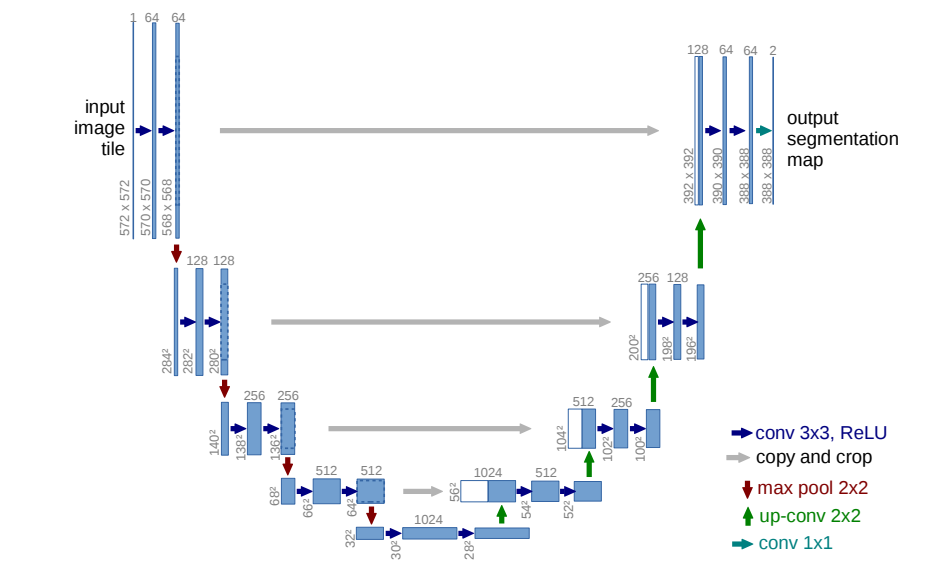

**⏰ U-NET MODEL FOR DENOISING TASK: MAIN DIFFERENCES**

1.   **Residual block**: instead of simple sequence of convolutional operations with activation functions,the residual block shows the normalization, the residual connection and the time embedding added after the first convolution.

2.   **Attention block**: the block performs an attention and a
skip connection in order to capture more information than the standard model.






**▶DEFINITION OF THE MACRO-BLOCKS FOR THE FINAL ARCHITECTURE**

⚓First start defining the **time embedding** in order to have an information about the timestep in our model.

The implementation creates a concatenation of sine and cosine values of the result of the element-wise multiplication of the tensor of timesteps and the generated frequencies.

The goal of the denoiser is to adapt the denoising to the different level of noise of each time step.


In [ ]:
import torch
import torch.nn as nn
import math

# Defining the Time Embeddings class
class TimeEmbeddings(nn.Module):
    def __init__(self, channels, device, max_period=10000):
        super(TimeEmbeddings, self).__init__()
        self.channels = channels
        self.device = device
        self.max_period = max_period
        self.half = self.channels // 2

        # Precomputing log(max_period) as a tensor on the specified device
        self.log_max_period = torch.tensor(math.log(self.max_period), dtype=torch.float32, device=self.device)

    def forward(self, t):

        # Generating sinusoidal frequencies using a logarithmic scale.
        freqs = torch.exp(-self.log_max_period * torch.arange(start=0, end=self.half, dtype=torch.float32, device=self.device) / self.half)

        # Computing args
        args = t * freqs[None]

        # Creating the embedding by concatenating the cosine and sine values.
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # If the embedding dimension is odd, append a column of zeros to ensure the output has the correct dimension.
        if self.channels % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1], device=self.device)], dim=-1)

        return embedding



**⏰Variant for the convolutional operation**


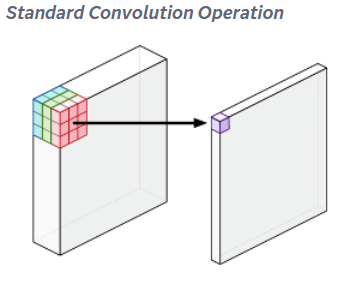

The standard convolution operation combines the values of all the input channels.

The total number of parameters
P in a standard convolutional layer can be expressed as:

**Total Parameters=(Wk ⋅ Hk ⋅ din ⋅ dout) + dout**

**Depthwise Separable Convolutions**

The depthwise separable convolution approach is a different, more efficient operation.

It is a two-step operation: first, a depthwise convolution, followed by a 1 x 1 pointwise convolution.


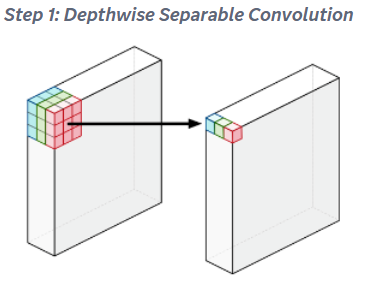

The depthwise convolution does not combine the input channels. It convolves on each channel separately so **each channel** gets its own set of weights.

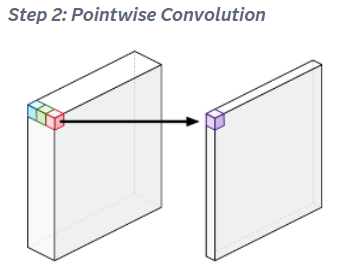

The pointwise convolution is essentially the same as a standard convolution, except using a 1 x 1 kernel. This operation just adds up the channels from the depthwise convolution as a weighted sum.

**Parameters Calculation**

1)For ***depthwise convolution***, the number of parameters is calculated as follows:

Parameters(Depthwise)=Wk
​⋅Hk
 ⋅din

2)For  ***pointwise convolution***, which combines the outputs from the depthwise convolution:

Parameters(Pointwise)=din
 ⋅dout


**Total Parameters=(Wk ⋅ Hk ⋅ din)+ (din ⋅ dout)**

In [ ]:
import torch.nn.functional as F

# Defining the depthwise separable convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        return self.pointwise(x)

⚓
Firstly the definition of the **residual block** with:

1. Time embedding

2. Groups Normalization

3. Activation function

4. Dropout factor of 0.1

5. Depthwise separable convolution





In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,embed_channels,activation, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()

        # Defining the first depthwise separable convolution with normalization and activation function
        self.conv1 = DepthwiseSeparableConv(in_channels, out_channels)
        self.norm1 = nn.GroupNorm(2, in_channels)
        self.act1 = activation

        # Defining the second  depthwise separable convolution  with  normalization nd activation function
        self.conv2 = DepthwiseSeparableConv(out_channels, out_channels)
        self.norm2 = nn.GroupNorm(2, out_channels)
        self.act2 =  activation

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Creating shortcuts for residual connections
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False) if in_channels != out_channels else nn.Identity()

        # Initializing linear layer for time-step embeddings
        self.time_emb = nn.Linear(embed_channels, out_channels)  # Projecting time embeddings to output channels
        self.time_act = activation

    def forward(self, x, t):
        # Performing the normalization, the activation function and the first convolution
        out = self.norm1(x)  # Normalizing
        out = self.act1(out)  # Activation function
        out = self.conv1(out)  # Convolution

        # Getting the shape of the output tensor
        batch_size, channels, height, width = out.shape

        # Compute the time embedding and adding necessary dimension
        time_embedding = self.time_emb(self.time_act(t))
        time_embedding = time_embedding.unsqueeze(dim=2).unsqueeze(dim=3)

        # Repeat the time embedding to match the spatial dimensions (height, width)
        time_embedding = time_embedding.repeat(1, 1, height, width)

        # Add the time embedding to the output
        out = out + time_embedding

        # Performing normalization,activation function,dropout and the second convolution
        out = self.norm2(out)  # Normalizing
        out = self.act2(out)  # Activation function
        out = self.dropout(out) # Dropout
        out = self.conv2(out)  # Convolution

        # Adding the residual connection
        shortcut=self.shortcut(x)
        out = out + shortcut # Adding the shortcut connection

        return out  # Returning the final output


⚓**The multi-head attention block** allows the model to focus on different parts of the input sequence simultaneously.

After obtaining the attention outputs from all heads, they are concatenated and passed through a final linear transformation and added to the original input.

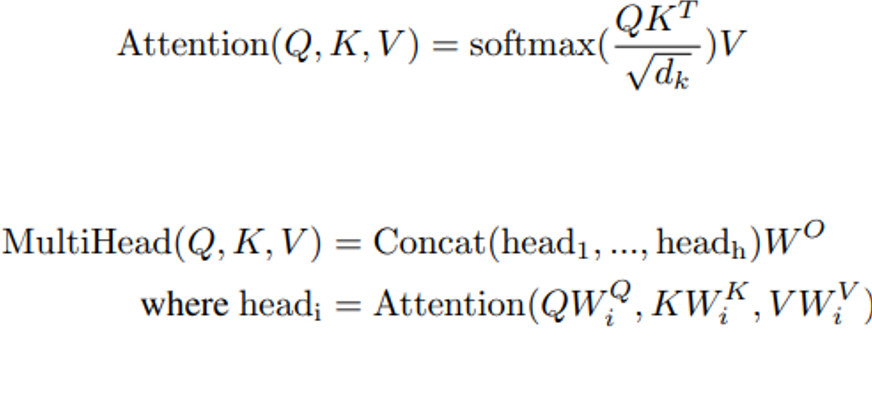

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads= 2):
        super().__init__()

        # Initializing the Multihead Attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=n_channels, num_heads=n_heads)

        # Final linear layer to transform the output back to original channel size
        self.output = nn.Linear(n_channels, n_channels)

        # Normalization
        self.norm = nn.GroupNorm(2, n_channels)

    def forward(self, x):
        #Normalizing
        x = self.norm(x)

        # Getting the shape of the input
        batch_size, n_channels, height, width = x.shape

        # Reshaing x to [seq, batch_size, n_channels] for rhe MultiHead attention function
        x = x.view(batch_size, n_channels, -1).permute(2, 0, 1)  # [seq, batch_size, n_channels]

        # Applying the Multihead Attention layer
        attn_output, attn_weights = self.multihead_attn(x, x, x)

        # Applying the final linear layer
        attn_output = self.output(attn_output)

        # Reshaping the output back to [batch_size, seq, n_channels]
        attn_output = attn_output.permute(1, 0, 2)  # Return to [batch_size, seq, n_channels]

        # Reshaping for the final output
        attn_output = attn_output.reshape(batch_size, n_channels, height, width)  # [batch_size, n_channels, height, width]

        # Adding the skip connection
        attn_output = attn_output + x.permute(0, 2, 1).reshape(batch_size, n_channels, height, width)  # [batch_size, n_channels, height, width]

        return attn_output



⚓The **DownBlock** class for down-sampling and applying attention if specified

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels,embed_channels, has_attn,activation):
        # Initializing
        super().__init__()

        # Creating a residual block to process the input
        self.res = ResidualBlock(in_channels, out_channels, embed_channels,activation)

        # Checking if attention should be included
        if has_attn:
            # Initializing the attention block if specified
            self.attn = AttentionBlock(out_channels)
        else:
            # Using an identity layer if no attention is needed
            self.attn = nn.Identity()

    # Defining the forward pass for the DownBlock
    def forward(self, x, t):
        # Processing the input through the residual block
        x = self.res(x, t)

        # Applying the attention mechanism (or identity) to the output
        x = self.attn(x)

        # Returning the processed output
        return x


⚓The **UpBlock** class for up-sampling and applying attention if specified.


In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_channels,has_attn,activation):
        # Initializing
        super().__init__()

        # Creating a residual block to process the input
        self.res = ResidualBlock(in_channels , out_channels, embed_channels,activation)

        # Checking if attention should be included
        if has_attn:
            # Initializing the attention block if specified
            self.attn = AttentionBlock(out_channels)
        else:
            # Using an identity layer if no attention is needed
            self.attn = nn.Identity()

    # Defining the forward pass for the UpBlock
    def forward(self, x, t):
        # Processing the input through the residual block
        x = self.res(x, t)

        # Applying the attention mechanism (or identity) to the output
        x = self.attn(x)

        # Returning the processed output
        return x


⚓
The **bottleneck class** for processing inputs with residual connections and attention


In [ ]:
class MiddleBlock(nn.Module):
    def __init__(self, n_channels, embed_channels,activation):
        # Initializing
        super().__init__()

        # Creating the first residual block to process the input
        self.res1 = ResidualBlock(n_channels, n_channels, embed_channels,activation)

        # Initializing the attention block to enhance feature representation
        self.attn = AttentionBlock(n_channels)

        # Creating the second residual block to further process the output after attention
        self.res2 = ResidualBlock(n_channels, n_channels, embed_channels,activation)

    # Defining the forward pass for the MiddleBlock
    def forward(self, x, t):
        # Processing the input through the first residual block
        x = self.res1(x, t)

        # Applying the attention mechanism to the output
        x = self.attn(x)

        # Processing the output through the second residual block
        x = self.res2(x, t)

        # Returning the final processed output
        return x


⚓
Class for the **scale up** and **scale down**.

In [ ]:
class ScaleClass(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))
        self.downsample= nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x, bool):
        if bool:
            return self.upsample(x)  # Scale up by doubling
        else:
            return self.downsample(x) #scale down by halfing

⚓Final **downsampling block** and **upsampling block** for the main architecture.

In [ ]:
class DownsamplingBlock(nn.Module):
    """Block for downsampling with residual connections and attention."""

    def __init__(self, in_channels, out_channels,embed_channels, use_attn,activation):
        super(DownsamplingBlock, self).__init__()
        self.downBlock= DownBlock(in_channels, out_channels, embed_channels, use_attn,activation)
        self.scale_down = ScaleClass(out_channels)

    def forward(self,x, t):
        x = self.downBlock(x, t)
        x = self.scale_down(x,False)
        return x


class UpsamplingBlock(nn.Module):
    """Block for upsampling with residual connections and attention."""

    def __init__(self, in_channels, out_channels, embed_channels, use_attn,activation):
        super(UpsamplingBlock, self).__init__()
        self.upBlock= UpBlock(in_channels, out_channels, embed_channels, use_attn,activation)
        self.scale_up = ScaleClass(out_channels)

    def forward(self, x, t) :
        x = self.upBlock(x, t)
        x = self.scale_up(x,True)
        return x


**▶FINAL MODEL**

**⏰VARIANTS FOR EXPERIMENTS**


1.   Classical standard convolution operations substituted by the **depthwise separable convolution**.
2. Single head substituted by **n-heads=2** in the attention block.

3. Training with 3 different activation function: **SilU,ReLU and GeLU**.




In [ ]:
# Defining the U-Net model
class UNet(nn.Module):
    def __init__(self,in_channels, out_channels,device,activation):
        super(UNet, self).__init__()

        # Time embedding
        self.model_channels=32
        self.device=device
        self.time_embeddings = TimeEmbeddings(self.model_channels,self.device)
        self.time_embed_dim = self.model_channels*4
        self.time_embed = nn.Sequential(
            nn.Linear(self.model_channels, self.time_embed_dim),
            activation,
            nn.Linear(self.time_embed_dim, self.time_embed_dim),
        )

        # Downsampling path
        self.down_block1 = DownsamplingBlock(in_channels, 4,self.time_embed_dim,False,activation)
        self.down_block2 = DownsamplingBlock(4, 8, self.time_embed_dim, False,activation)
        self.down_block3 = DownsamplingBlock(8, 16, self.time_embed_dim, False,activation)

        # Middle block
        self.mid_block = MiddleBlock(16, self.time_embed_dim,activation)

        # Upsampling path
        self.up_block1 = UpsamplingBlock(16, 8, self.time_embed_dim, False,activation)
        self.up_block2 = UpsamplingBlock(8, 4, self.time_embed_dim, False,activation)
        self.up_block3 = UpsamplingBlock(4, out_channels, self.time_embed_dim, False,activation)
        self.proj1 = nn.Conv2d(16,8, kernel_size=1, stride=1, padding=0)
        self.proj2 = nn.Conv2d(8,4, kernel_size=1, stride=1, padding=0)
        self.proj3 = nn.Conv2d(4,out_channels, kernel_size=1, stride=1, padding=0)

        # Final layers
        self.final_norm = nn.GroupNorm(2, out_channels)
        self.final_act = activation
        self.final_conv = DepthwiseSeparableConv(out_channels, out_channels)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embeddings(t)
        t_emb = self.time_embed(t_emb)

        # Storing initial data
        x_in=x

        # Downsampling path
        x1 = self.down_block1(x, t_emb)
        x2 = self.down_block2(x1, t_emb)
        x3 = self.down_block3(x2, t_emb)

        # Middle block
        x_mid = self.mid_block(x3, t_emb)

        # Upsampling path
        x = self.up_block1(x_mid, t_emb)
        x = torch.cat((x, x2), dim=1)  # Concatenating with skip connection
        x = self.proj1(x)
        x = self.up_block2(x, t_emb)
        x = torch.cat((x, x1), dim=1)  # Concatenating with skip connection
        x = self.proj2(x)
        x = self.up_block3(x, t_emb)
        x = torch.cat((x, x_in), dim=1)  # Concatenating with skip connection
        x = self.proj3(x)

        # Final layers
        x = self.final_norm(x)
        x = self.final_act(x)
        x = self.final_conv(x)
        return x

**▶DDPM**

During the **diffusion process** gaussian noise is gradually added in order to achieve the total noise.

Then the Compact U-Net is trained to predict the noise added in order to **reverse the process** and restore the original data.

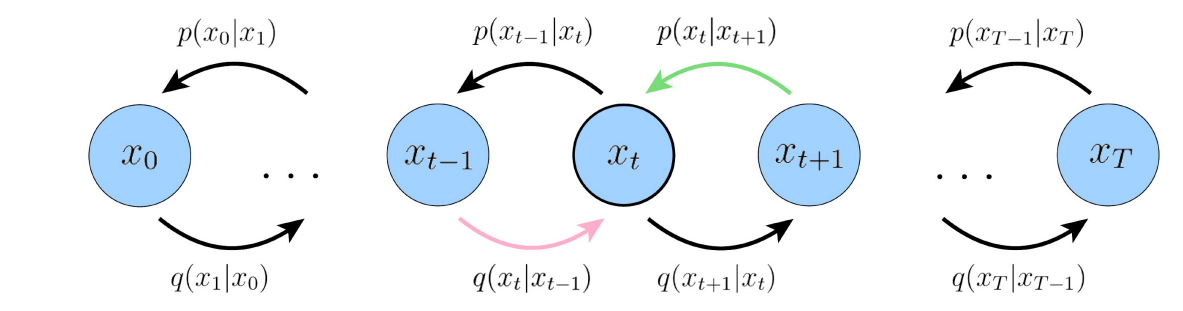

In [ ]:
    def cosine_beta_schedule(timesteps,device, s=0.008):
      # Generating a cosine beta schedule for the given number of timesteps.
      steps = timesteps + 1
      x = torch.linspace(0, timesteps, steps, dtype=torch.float64).to(device)
      alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
      alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
      betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
      return torch.clip(betas, 0, 0.9999)

In [ ]:
# Defining the Diffusion Model class
class DiffusionModel(nn.Module):
    def __init__(self, unet_model, timesteps,device):
        super(DiffusionModel, self).__init__()
        self.device=device
        self.unet_model = unet_model.to(self.device)
        self.timesteps = timesteps

        # Defining cosine variance schedule
        self.betas = cosine_beta_schedule(self.timesteps,self.device)
        self.sqrt_betas = torch.sqrt(self.betas)

        # Defining alphas
        self.alphas = 1 - self.betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-self.alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)


    # Perturbing the data to generate a noisy sample x_t.
    def add_noise(self, x, t):
        # Perturbing x
        epsilon = torch.randn_like(x).to(self.device)

        #Extracting the parameters for timestep t
        t=t.item()
        sqrt_alpha_bar=self.sqrt_alpha_bars
        sqrt_ab=sqrt_alpha_bar[t]
        sqrt_one_minus_alpha_bar=self.sqrt_one_minus_alpha_bars
        sqrt_mab=sqrt_one_minus_alpha_bar[t]

        # Generating noisy sample (forward process)
        noisy_sample = x * sqrt_ab + epsilon * sqrt_mab

        return noisy_sample, epsilon

    # Perturbing the input audio and predicts the noise added at each timestep
    def add_noise_and_predict(self, x,random_t):
        # Perturbing x
        perturbed_audio, epsilon = self.add_noise(x, random_t)

        # Predict epsilon (noise) given perturbed data at diffusion timestep t
        pred_epsilon = self.unet_model(perturbed_audio, random_t)

        return epsilon, pred_epsilon

    # Predicting the completed denoised signal x_0 at timestep t
    def denoise_at_t(self, x_t, timestep):
        # Predicting epsilon at timestep t
        with torch.no_grad():
          self.unet_model.eval()
          epsilon_pred = self.unet_model(x_t, timestep)

        # Extracting the parameters for timestep t
        sqrt_alpha_bar=self.sqrt_alpha_bars[timestep]
        sqrt_one_minus_alpha_bar=self.sqrt_one_minus_alpha_bars[timestep]

        # Applying the denoising formula
        x_0 = (x_t - sqrt_one_minus_alpha_bar * epsilon_pred) / sqrt_alpha_bar

        return x_0



**▶Training**




⚓The task of the denoiser is the **prediction of the noise** added for the specific random timestep.

The **loss** will be the **MSE** between the 2 value of the real noise and the predicted one.

The **random timestep** is due to the final goal of training the denoiser to predict every kind of possible level of noise.

⚓
The code also includes:

1. **Model Checkpointing**: The model is saved after every epoch to Google Drive, ensuring progress isn't lost.

2. **Evaluation**: After each epoch, the performance is evaluated on a separate dataset.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

drive.mount('/content/drive')

# Creating the directory for the checkpoint if it doesn't exist
checkpoint_dir = '/content/drive/My Drive/Diffusion_model_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining the filename for the checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')

def train_diffusion_model(model, dataloader,checkpoint_path, optimizer, criterion, device, eval_dataloader, num_epochs):

    # Defining the scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, min_lr=1e-6)

    for epoch in range(num_epochs):
      # Loading the model if it's not the first epoch
        if epoch > 0 and os.path.exists(checkpoint_path):
            model.load_state_dict(torch.load(checkpoint_path))
            print(f"Model loaded from {checkpoint_path} at the start of epoch {epoch + 1}")
        total_loss = 0.0

        # Setting the model to training mode
        model.train()
        # Looping through the training data
        for data in dataloader:
            data = data.to(device)
            data=data.squeeze(dim=1)
            optimizer.zero_grad()

            # Computing z-score normalization
            mean = torch.mean(data, axis=(2, 3), keepdims=True)
            std_dev = torch.std(data, axis=(2, 3), keepdims=True)
            data_normalized = (data - mean) / std_dev
            data = data_normalized.to(device)

            # Randomly choose diffusion time-step
            random_t = torch.randint(0, model.timesteps, (1,)).to(device)

            epsilon, pred_epsilon = model.add_noise_and_predict(data, random_t)

            # Calculating the loss with respect to the original data
            loss = criterion(epsilon, pred_epsilon)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulating the loss

        avg_loss = total_loss / len(dataloader)  # Calculating the average loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_loss:.4f}')

         # Save the model at the end of each epoch
        torch.save(model.state_dict(), checkpoint_path)  # Save the model state

        # Evaluating the model at the end of each epoch if eval_dataloader is provided
        if eval_dataloader is not None:
            model.eval()  # Setting the model to evaluation mode
            total_eval_loss = 0.0  # Initializing total evaluation loss

            # Disabling gradient calculation for evaluation
            with torch.no_grad():
                for eval_data in eval_dataloader:
                    eval_data = eval_data.to(device)
                    eval_data=eval_data.squeeze(dim=1)

                    # Computing z-score normalization
                    mean = torch.mean(eval_data, axis=(2, 3), keepdims=True)
                    std_dev = torch.std(eval_data, axis=(2, 3), keepdims=True)
                    data_normalized = (eval_data - mean) / std_dev
                    eval_data = data_normalized.to(device)

                    # Randomly choose diffusion time-step
                    random_t = torch.randint(0, model.timesteps, (1,)).to(device)

                    #Extracting epsilon and predicted epsilon
                    epsilon, pred_epsilon = model.add_noise_and_predict(eval_data, random_t)

                    # Calculating the loss with respect to the original data
                    eval_loss = criterion(epsilon, pred_epsilon)
                    total_eval_loss += eval_loss.item()

            # Calculating the average evaluation loss
            avg_eval_loss = total_eval_loss / len(eval_dataloader)

            #Updating the scheduler
            scheduler.step(avg_eval_loss)

            # Printing the average evaluation loss
            print(f'Average Evaluation Loss: {avg_eval_loss:.4f}')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
activation = nn.ReLU()
unet_model = UNet(2, 2, device,activation).to(device)
diffusion_model = DiffusionModel(unet_model,50,device).to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=0.001,weight_decay=0.0001)
criterion = nn.MSELoss()

train_diffusion_model(diffusion_model, DBG_train_data_loader,checkpoint_path, optimizer, criterion, device, DBG_eval_data_loader, 100)



**▶Testing**


⚓Testing considering the average loss.

In [ ]:
# Defining the function to test the diffusion model
def test_diffusion_model(model, test_dataloader,criterion, device):
    model.eval()  # Setting the model to evaluation mode
    total_test_loss = 0.0  # Initializing total test loss

    # Disabling gradient calculation for testing
    with torch.no_grad():
        for test_data in test_dataloader:
                    test_data = test_data.to(device)
                    test_data=test_data.squeeze(dim=1)

                    # Computing z-score normalization
                    mean = torch.mean(test_data, axis=(2, 3), keepdims=True)
                    std_dev = torch.std(test_data, axis=(2, 3), keepdims=True)
                    data_normalized = (test_data - mean) / std_dev
                    test_data = data_normalized.to(device)

                    # Randomly choose diffusion time-step
                    random_t = torch.randint(0, model.timesteps, (1,)).to(device)

                    #Extracting epsilon and predicted epsilon
                    epsilon, pred_epsilon = model.add_noise_and_predict(test_data, random_t)

                    # Calculating the loss with respect to the original data
                    test_loss = criterion(epsilon, pred_epsilon)
                    total_test_loss += test_loss.item()

        # Calculating the average test loss
        avg_test_loss = total_test_loss / len(test_dataloader)

        # Printing the average test loss
        print(f'Average Test Loss: {avg_test_loss:.4f}')

test_diffusion_model(diffusion_model, DBG_test_data_loader,criterion, device)




Average Test Loss: 0.0963


**ALGORITHM**

⚓Here the code of the algorithm with the pattern "Diffiner" and metrics for the testing.

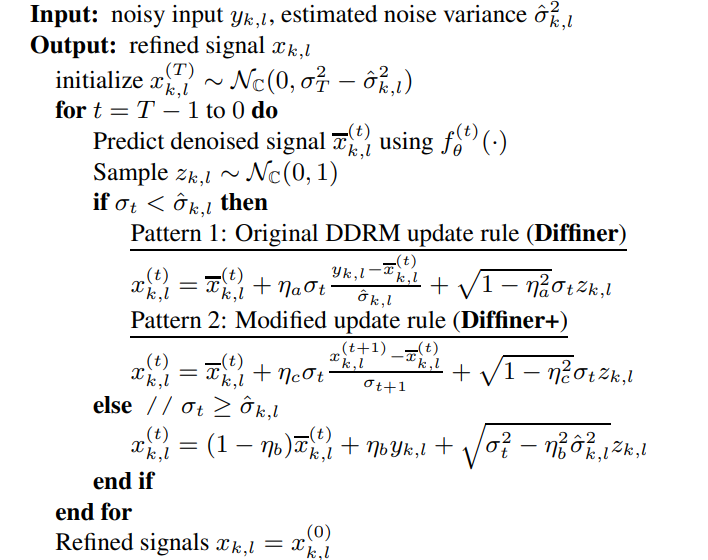

⚓Definition of utility functions.

In [ ]:
import numpy as np
import torchaudio.transforms as T
import torch
import torch.nn.functional as F


def estimate_variance(y, x, lambda_param=1.0, delta=1.0e-5, R=97):
    # Estimate noise signal
    n_hat = y.cpu().numpy()-x.cpu().numpy()
    sigma=[]

    # Estimating the variance of the noise signal
    # Calculating the squared magnitude of the estimated noise signal
    for i in range(n_hat.shape[0]):
      n = n_hat[i,:,:,:]

      # Separating two channels
      real = n[0, :, :]
      imag = n[1, :, :]

      # Computing the n_hat_squared
      n_hat_squared = real**2 + imag**2

      # Computing the modeled variance
      sigma_hat_squared = np.minimum(
          np.maximum(lambda_param * n_hat_squared, delta), R
      )
      sigma.append(sigma_hat_squared)

    sigma_hat_squared = torch.tensor(np.stack(sigma), dtype=torch.float32).to(device)

    return sigma_hat_squared

def initialize_x_t(sigma_T, sigma_hat_squared):
    # Calculating the variance for the complex normal distribution
    variance = (sigma_T - sigma_hat_squared)

    # Ensuring variance is non-negative, clipping values below 0 to 0
    variance = torch.clamp(variance, min=0.0)  # Clip negative values

    #Computing the standard deviation
    std=torch.sqrt(variance)

    # Generating the real part and the imaginary part of the tensor
    real_part = torch.normal(mean=0.0, std=std).cpu().numpy()
    imag_part = torch.normal(mean=0.0, std=std).cpu().numpy()

    # Stacking the real and imaginary parts into a two-channel tensor
    x_t = np.stack((real_part, imag_part), axis=1)  # Final shape: (8,2, 256, 256)

    return torch.tensor(x_t).to(device)

def compute_STFT(waveform, device):
    # Defining the STFT parameters
    n_fft = 512
    hop_length = 256
    win_length = 512
    window = torch.hann_window(win_length, device=device)

    # Ensuring waveform has correct shape (batch_size, num_samples)
    if waveform.shape[1] == 1:
        waveform = waveform.squeeze(1)  # Removing extra channel dimension

    # Performing STFT
    stft_spectrogram = torch.stft(
        waveform,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        return_complex=True
    ).to(device)

    # stft_spectrogram shape: (batch_size, freq_bins, time_frames)
    # Truncation of the DC component
    stft_spectrogram = stft_spectrogram[:, 1:, :]  # Removing DC component

    # Extraction of real and imaginary parts
    real_part = stft_spectrogram.real
    imag_part = stft_spectrogram.imag

    # Stacking into a tensor with two channels (real and imaginary)
    two_channel_tensor = torch.stack((real_part, imag_part), dim=1)

    # Ensuring the size is 256x256
    # Padding or truncating frequency and time dimensions if necessary
    two_channel_tensor = F.pad(two_channel_tensor, (0, max(0, 256 - two_channel_tensor.shape[-1]),
                                                   0, max(0, 256 - two_channel_tensor.shape[-2])))
    two_channel_tensor = two_channel_tensor[:, :, :256, :256]  # Ensure shape (batch_size, 2, 256, 256)

    return two_channel_tensor

def compute_inverse_STFT(two_channel_tensor, device):
    # STFT parameters (should match the ones used in the forward STFT)
    n_fft = 512
    hop_length = 256
    win_length = 512
    window = torch.hann_window(win_length, device=device)

    # Ensure the input has the correct shape (batch_size, 2, 256, 256)
    if two_channel_tensor.shape[1] != 2:
        raise ValueError("Expected input to have two channels: real and imaginary parts.")

    batch_size = two_channel_tensor.shape[0]  # Get the batch size

    # Extracting the real and imaginary parts
    real_part = two_channel_tensor[:, 0, :, :]  # Shape: (batch_size, freq_bins, time_frames)
    imag_part = two_channel_tensor[:, 1, :, :]  # Shape: (batch_size, freq_bins, time_frames)

    # Reconstructing the complex tensor from real and imaginary parts
    stft_spectrogram = torch.complex(real_part, imag_part)  # Shape: (batch_size, freq_bins, time_frames)

    # Adding back the DC component
    stft_spectrogram = F.pad(stft_spectrogram, (0, 0, 1, 0))  # Add the first frequency bin (DC)

    # Performing the inverse STFT for each batch
    reconstructed_waveform = torch.istft(
        stft_spectrogram.view(-1, stft_spectrogram.size(1), stft_spectrogram.size(2)),  # Reshape for istft
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
    )

    # Reshape the output back to (batch_size, waveform_length)
    waveform_length = reconstructed_waveform.size(1)  # Length of reconstructed waveforms
    return reconstructed_waveform.view(batch_size, -1)


⚓Definition of the final algorithm with the pattern "Diffiner".

In [ ]:
def Diffiner_algorithm(noisy_audio, eta_a, eta_b,diffusion_model,generator,device,timesteps=50):

    STFT_noisy=compute_STFT(noisy_audio,device)
    generator.eval()
    with torch.no_grad():
      output_SEGAN = generator(noisy_audio)
    STFT_SEGAN=(compute_STFT(output_SEGAN,device)).cpu()
    estimation=estimate_variance(STFT_noisy, STFT_SEGAN)
    sigma_hat_squared=estimation

    # Computing sigma_T
    betas=diffusion_model.betas
    sigma_T_squared = betas[timesteps-1]

    #Initializing refined_x_t
    refined_x_t=initialize_x_t( sigma_T_squared, sigma_hat_squared)

    diffusion_model.eval()
    with torch.no_grad():
      for t in reversed(range(timesteps-2)):
          # Predicting x_0 at each timestep t
          predicted_x_t = (diffusion_model.denoise_at_t(refined_x_t,t)).cpu()

          # Sampling z from NC(0, 1)
          z = (torch.randn_like(predicted_x_t).to(device)).cpu()  # Standard normal distribution

          # Computing sigma_hat
          sigma_hat = torch.sqrt(sigma_hat_squared)
          sigma_hat = (sigma_hat.unsqueeze(1).repeat(1, 2, 1, 1)).cpu()

          #Computing sigma_t
          sigma_t = (torch.sqrt(betas[t])).cpu()

          # Computing the mask for the uploading
          mask = sigma_t < sigma_hat

          # Computing the uploading
          refined_x_t = np.where(
              mask.cpu(),
              predicted_x_t + eta_a * sigma_t * ((STFT_SEGAN - predicted_x_t) / sigma_hat) + (((1 - eta_a**2)**0.5) * sigma_t * z),
              (1 - eta_b) * predicted_x_t + eta_b * STFT_SEGAN + (((sigma_t**2 - eta_b**2 * sigma_hat**2)**0.5)) * z
          )

          refined_x_t = torch.from_numpy(refined_x_t).to(device)

      return refined_x_t  # Return the final refined audio


⚓Creating a test data loader on noisy signal.

In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')
waveform_noisy_test_preprocessed_dir = '/content/drive/My Drive/waveform_noisy_test_preprocessed'
test_samples= load_samples(waveform_noisy_test_preprocessed_dir)

test=[]
for i in range(len(test_samples)):
  if i>23:
    break
  test.append(test_samples[i])

test_samples=torch.stack(test)

# Creation of the DataLoader
batch_size = 8
Test_dataset= ProcessedAudioDataset(test_samples)
Test_data_loader = DataLoader(Test_dataset, batch_size=batch_size, shuffle=False)

⚓Testing of the diffiner algorithm with the NISQA metrics for comparison with the paper results.

In [ ]:
!git clone https://github.com/gabrielmittag/NISQA

In [ ]:
import torch
import soundfile as sf
import os
import numpy

# Creating the directories for the final results
result_dir = "content/result"
os.makedirs(result_dir, exist_ok=True)
audio_dir = "content/audio/"
os.makedirs(audio_dir, exist_ok=True)

def test_diffiner_algorithm(data_loader, eta_a, eta_b,diffusion_model,generator,device,audio_dir,result_dir):
    audio_id = 0  # Initializing count of audio

    with torch.no_grad():
      # Loop over batches in the DataLoader
      for noisy_audios in data_loader:
          noisy_audios = noisy_audios.to(device)  # Move noisy audio to the specified device
          # Refining the noisy audio using the Diffiner algorithm
          refined_audio = Diffiner_algorithm(noisy_audios, eta_a, eta_b,diffusion_model,generator,device)
          refined_audio_wav = compute_inverse_STFT(refined_audio,device)

          for audio in refined_audio_wav:
              # Definining wav_file path
              audio_id += 1
              wav_filepath = os.path.join(audio_dir, f"{audio_id}.wav")

              # Saving the file
              audio=audio.cpu()
              audio = audio.numpy()
              sf.write(wav_filepath, audio, 16000,format='WAV')

      !python NISQA/run_predict.py --mode predict_dir --pretrained_model NISQA/weights/nisqa.tar --data_dir content/audio --num_workers 0 --bs 10 --output_dir content/result

# Setting the eta_values
eta_a = 0.8
eta_b = 0.8

# Checkpoint path
checkpoint_path = '/content/drive/My Drive/Diffusion_model_checkpoint/model_checkpoint.pth'

# Loading checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
activation = nn.ReLU()
unet_model = UNet(2, 2, device,activation).to(device)
diffusion_model = DiffusionModel(unet_model,50,device).to(device)

# Loading from the checkpoint
diffusion_model.load_state_dict(checkpoint)

#Checkpoint path
checkpoint_path='/content/drive/My Drive/Segan_model_checkpoint/model_checkpoint.pth'

# Loading checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Instance of the model
generator = Generator().to(device)

#Loading from the checkpoint
generator.load_state_dict(checkpoint['generator_state_dict'])

# Evaluation mode
diffusion_model.eval()
generator.eval()

# Perform testing of the Diffiner algorithm
test_diffiner_algorithm(Test_data_loader,eta_a, eta_b,diffusion_model,generator,device,audio_dir,result_dir)



<ipython-input-28-e1077dd3f799>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
<ipython-input-2

Device: cuda
/content/NISQA/nisqa/NISQA_model.py:938: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.dev)
Model architec

**▶RESULTS FOR THE SEGAN GENERATOR**

For the **SEGAN** model we trained for 65 epochs with the Adam optimizer,a learning rate of 0.001 and a "Reduce on Plateau" scheduler.

During the evaluation,after some instability, we finally reached a smooth behavior in the last 9 epochs and a finally average loss on the test set of 0.0535.

![Screenshot 2024-10-23 010352](https://github.com/user-attachments/assets/7475be4d-f46f-4f94-86de-ddd94f53713e)

**▶RESULTS FOR THE DIFFUSION MODEL**


For the **Diffusion model** we trained with timesteps=50 for 100 epochs with the Adam optimizer,a learning rate of 0.001 and a "Reduce on Plateau" scheduler.

 We trained 3 times in order to experiment with 3 different activation functions : SILU, RELU and GELU

 -  Evaluation phase with **SILU**
   
    ![Screenshot 2024-10-23 003202](https://github.com/user-attachments/assets/a24fe2f9-48bb-47cb-83dc-279277e8c2c2)


-  Evaluation phase with **RELU**
  
   ![Screenshot 2024-10-23 004406](https://github.com/user-attachments/assets/0a2688b1-4690-4019-ae78-073d4b341570)


-  Evaluation phase with **GELU**

   ![Screenshot 2024-10-23 004934](https://github.com/user-attachments/assets/ef6498c7-44d9-4323-8016-52b25b6512ef)

   
In the 3 cases we obtained similar results but with some better performances in the RELU case, in wich the loss seems to converge around 0.1.

Here the result of the final average loss during the test:

1. SILU : 0.1201
  
2. **RELU : 0.0963**

3. GELU : 0.1136


**▶METRICS**

We choose the NISQA metrics in order to evaluaate the performance of the algorithm with these metrics:

- **Overall Quality (MOS_pred)**: Higher values mean better overall speech quality (1-5 scale).

- Noisiness (Noi_pred): Higher values mean more background noise.

- Coloration (Col_pred): Higher values indicate more tonal changes or unnatural sound.

- Discontinuity (Dis_pred): Higher values mean more distortion or breaks in the audio.

- Loudness (Loud_pred): Higher values mean louder speech.


**▶FINAL RESULTS OF THE REFINER**


- Final results with **SILU**
  
  ![silu](https://github.com/user-attachments/assets/1876b114-a61a-4c60-85a7-5230b1758b91)

- Final results with **RELU**

![relu](https://github.com/user-attachments/assets/78d68bc7-2e12-4d82-acd2-78e2d89fa004)

 - Final results with **GELU**

  ![gelu](https://github.com/user-attachments/assets/51298f92-4715-40bc-9b43-f62a0a9f7f74)

  
**▶FINAL CONSIDERATIONS ON THE RESULTS**

In all the experminets the low values of coloration and discontinuity indicates small presence of unnatural sound and distorsion.

For comparison with the paper we mainly focus on the overall speech quality(MOS_pred) in wich the paper has reached (with the SEGAN model and the Diffiner pattern) a result of 4.372. This result is due to the training of the diffusion model for which they trained the model on a single NVIDIA A100 GPU (40 GB memory) for 7.5 × 10^5 steps, which took about three days. Obviously our results with only 100 epochs and 50 timesteps in the final algorithm (T=200 in the paper) is inevitably lower.

But the interesting part is that the **RELU experiments** has respected our previsions.In fact ,as we have already said, this was the experiment that showed the better performance during the evaluation and the lower final average test loss and ,as a consequence, we reached the better result in terms of MOS_pred scores.
